# Literature Search Crawl Report

Generate various stats validations from the artifacts of the literature search

In [1]:
import os
import re
import requests
import json
import sqlite3
import pandas as pd
import pprint
    
os.chdir(os.path.expanduser("/home/jovyan/data/literature-search/crawl/"))

In [2]:
print("Stats for crawl on", open("pubs-date.txt").read())

Stats for crawl on 2019-04-27T22:12:11


## Download

In [3]:
with open("pmids.txt") as f:
    pmids = set(f.read().splitlines())
print("{} PMIDs attempted".format(len(pmids)))

17716 PMIDs attempted


In [4]:
download = pd.read_csv("docStatus.tab",
                       sep="\t", header=None, index_col=False, dtype=str,
                       names=["pmid", "status", "msg", "crawler", "journal", "year", "numFiles", "detail"])

print("{} ({}%) succeeded\n {} ({}%) failed\n".format(
    download[download.status == "OK"].shape[0], 
    round(100 * download[download.status == "OK"].shape[0] / len(pmids)),
    download[download.status != "OK"].shape[0], 
    round(100 * download[download.status != "OK"].shape[0] / len(pmids))))
print(download.status.value_counts())

14734 (83%) succeeded
 2985 (17%) failed

OK                     14734
invalidPdf              1004
noCrawlerSuccess         890
httpError                320
noLicense                312
HighwirePdfNotValid      261
ovidMetaParseFailed       90
invalidHostname           55
pageErrorMessage          32
no_meta                    9
noOutlinkOrDoi             6
noSpringerLicense          3
tooManySupplFiles          1
BeautifulSoupError         1
HtmlParseError             1
Name: status, dtype: int64


## Find

In [5]:
variants = pd.read_csv("built_with_change_types.tsv",
                       sep="\t", header=0, encoding="utf-8",
                       usecols=["pyhgvs_Genomic_Coordinate_38", "pyhgvs_cDNA", "Synonyms"])
    
print("{} variants in BRCA Exchange".format(variants.shape[0]))

mentions = pd.read_csv("mutations-trimmed.tsv",
                       sep="\t", header=0, encoding="utf-8", dtype="str")
print("{} mentions found".format(mentions.shape[0]))

matches = pd.read_csv("mentions-matched.tsv", sep="\t", header=0, encoding="utf-8")
print("{} matches found".format(matches.shape[0]))

24662 variants in BRCA Exchange
450605 mentions found
192557 matches found


In [6]:
print(matches.points.describe())

count    192557.000000
mean          5.363695
std           3.328039
min           1.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          50.000000
Name: points, dtype: float64


In [7]:
with open("literature.json") as f:
    lit = json.loads(f.read())
print("{} Papers and {} Variants exported".format(len(lit["papers"]), len(lit["variants"])))

3961 Papers and 10964 Variants exported


In [10]:
print("{} Papers  didn't yield any variants".format(len(list(set(pmids) - set(lit["papers"].keys())))))

13756 Papers  didn't yield any variants


In [19]:
# print("Max mentions for a single variant: {} {}".format(
#     exploded.groupby(["pyhgvs_Genomic_Coordinate_38"]).size().idxmax(),
#     exploded.groupby(["pyhgvs_Genomic_Coordinate_38"]).size().max()))

# print("Max mentions for a single paper from one variant: {} {}".format(
#     exploded.groupby(["pyhgvs_Genomic_Coordinate_38", "pmid"]).size().idxmax(),
#     exploded.groupby(["pyhgvs_Genomic_Coordinate_38", "pmid"]).size().max()))

# print("Paper referenced from the most variants: {} {}".format(
#     exploded.groupby(["pmid"]).size().idxmax(),
#     exploded.groupby(["pmid"]).size().max()))

## Founder Mutations

Make sure the variant matches to several founder mutation articles as reported [here](https://github.com/BRCAChallenge/pubMunch-BRCA/issues/10) are present.

In [11]:
# Make sure all the articles were in the crawl
assert set(['12473589', '15994883', '9042909', '21987798', '16397213', '20608970', '11352856', 
 '9145676', '25192939', '21598239', '28122244', '14576434', '20215531', '18158280', '22430266']).issubset(pmids)

In [12]:
# BRCA1 185delAG: https://brcaexchange.org/variant/183889
# chr17:g.43124027:ACT>A
text = """
Abeliovich et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9042909 (in article title)
Antoniou et al. 2005 à https://www.ncbi.nlm.nih.gov/pubmed/15994883 (in article title)
Chodick et al. 2008 à https://www.ncbi.nlm.nih.gov/pubmed/18158280 (in article abstract)
Elstrodt et al. 2006 à https://www.ncbi.nlm.nih.gov/pubmed/16397213 (in article abstract)
Finkelman et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/22430266 (in article abstract)
Gabai-Kapara et al. 2014 à https://www.ncbi.nlm.nih.gov/pubmed/25192939 (in article introduction and methods)
King et al. 2003 à https://www.ncbi.nlm.nih.gov/pubmed/14576434 (in article)
Konishi et al. 2011 à https://www.ncbi.nlm.nih.gov/pubmed/21987798 (in abstract)
Linger and Kruk 2010 à https://www.ncbi.nlm.nih.gov/pubmed/20608970 (in article)
Satagopan et al. 2001 à https://www.ncbi.nlm.nih.gov/pubmed/11352856 (in abstract)
Satagopan et al. 2002 à https://www.ncbi.nlm.nih.gov/pubmed/12473589 (in abstract)
Stadler et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/21598239 (in abstract)
Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9145676 (in abstract)

Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/111111 Spikein :-)
"""
print(set(re.findall(r"\/(\d+)", text)).difference(
    set([v["pmid"] for v in lit["variants"]["chr17:g.43124027:ACT>A"]])))
print("Not Crawled:", set(re.findall(r"\/(\d+)", text)) - set(pmids))

{'111111'}
Not Crawled: {'111111'}


In [13]:
# **BRCA1 5382insC: https://brcaexchange.org/variant/180141**
# chr17:g.43057062:T>TG
text = """
Abeliovich et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9042909 (in article title)
Antoniou et al. 2005 à https://www.ncbi.nlm.nih.gov/pubmed/15994883 (in article title)
Finkelman et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/22430266 (in article)
Gabai-Kapara et al. 2014 à https://www.ncbi.nlm.nih.gov/pubmed/25192939 (in article introduction and methods)
King et al. 2003 à https://www.ncbi.nlm.nih.gov/pubmed/14576434 (in article)
Mgbemena et al. 2017 à https://www.ncbi.nlm.nih.gov/pubmed/28122244 (in abstract)
Satagopan et al. 2002 à https://www.ncbi.nlm.nih.gov/pubmed/12473589 (in abstract)
Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9145676 (in abstract)

Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/111111 Spikein :-)
"""
print(set(re.findall(r"\/(\d+)", text)).difference(
    set([v["pmid"] for v in lit["variants"]["chr17:g.43057062:T>TG"]])))
print("Not Crawled:", set(re.findall(r"\/(\d+)", text)) - set(pmids))

{'111111', '28122244'}
Not Crawled: {'111111'}


In [14]:
# **BRCA2 6174delT: https://brcaexchange.org/variant/177049**
# chr13:g.32340526:AT>A
text = """
Abeliovich et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9042909 (in article title)
Antoniou et al. 2005 à https://www.ncbi.nlm.nih.gov/pubmed/15994883 (in article title)
Chodick et al. 2008 à https://www.ncbi.nlm.nih.gov/pubmed/18158280 (in article abstract)
Finkelman et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/22430266 (in article abstract)
Gabai-Kapara et al. 2014 à https://www.ncbi.nlm.nih.gov/pubmed/25192939 (in article introduction and methods)
Gallagher et al. 2010 à https://www.ncbi.nlm.nih.gov/pubmed/20215531 (in methods)
King et al. 2003 à https://www.ncbi.nlm.nih.gov/pubmed/14576434 (in article)
Satagopan et al. 2001 à https://www.ncbi.nlm.nih.gov/pubmed/11352856 (in abstract)
Satagopan et al. 2002 à https://www.ncbi.nlm.nih.gov/pubmed/12473589 (in abstract)
Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9145676 (in abstract)

Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/111111 Spikein :-)
"""
print(set(re.findall(r"\/(\d+)", text)).difference(
    set([v["pmid"] for v in lit["variants"]["chr13:g.32340526:AT>A"]])))
print("Not Crawled:", set(re.findall(r"\/(\d+)", text)) - set(pmids))

{'111111'}
Not Crawled: {'111111'}


## HGMD for chr13:g.32363367:C>G

In [15]:
text = """
1. Fackenthal (2002) Am J Hum Genet 71: 625 PubMed: 12145750 
BRCA2 T2722R is a deleterious allele that causes exon skipping.
2. Karchin (2008) Cancer Inform 6: 203 PubMed: 19043619
Classifying Variants of Undetermined Significance in BRCA2 with protein likelihood ratios.
3. Kuznetsov (2008) Nat Med 14: 875 PubMed: 18607349
Mouse embryonic stem cell-based functional assay to evaluate mutations in BRCA2.
4. Lindor (2012) Hum Mutat 33: 8 PubMed: 21990134
A review of a multifactorial probability-based model for classification of BRCA1 and BRCA2 variants of uncertain significance (VUS).
5. Guidugli (2013) Cancer Res 73: 265 PubMed: 23108138
A classification model for BRCA2 DNA binding domain missense variants based on homology-directed repair activity.
6. Guidugli (2014) Hum Mutat 35: 151 PubMed: 24323938
Functional assays for analysis of variants of uncertain significance in BRCA2.
7. Hendriks (2014) Hum Mutat 35: 1382 PubMed: 25146914
An Efficient Pipeline for the Generation and Functional Analysis of Human BRCA2 Variants of Uncertain Significance.
8. Fraile-Bethencourt (2017) PLoS Genet 13: 1006691 PubMed: 28339459
Functional classification of DNA variants by hybrid minigenes: Identification of 30 spliceogenic variants of BRCA2 exons 17 and 18.
9. Meisel (2017) Arch Gynecol Obstet 295: 1227 PubMed: 28324225
Spectrum of genetic variants of BRCA1 and BRCA2 in a German single center study.
10. Guidugli (2018) Am J Hum Genet : PubMed: 29394989
Assessment of the Clinical Relevance of BRCA2 Missense Variants by Functional and Computational Approaches.
11. Rebbeck (2018) Hum Mutat 39: 593 PubMed: 29446198
"""
print("Missing from HGMD", set(re.findall(r"PubMed: (\d+)", text)).difference(
    set([v["pmid"] for v in lit["variants"]["chr13:g.32363367:C>G"]])))
print("Not Crawled:", set(re.findall(r"\/(\d+)", text)) - set(pmids))

hgmd = {hgmd[1]: int(hgmd[0]) for hgmd in re.findall(r"(\d+)\..*?PubMed: (\d+)", text)}

print("pmid\t\tpoints\t#snips\tHGMD")
for hit in lit["variants"]["chr13:g.32363367:C>G"]:
    print("{}\t{}\t{}\t{}".format(
        hit["pmid"], hit["points"], len(hit["mentions"]),
        hgmd[hit["pmid"]] if hit["pmid"] in hgmd else "-"))


Missing from HGMD {'29394989', '29446198', '19043619'}
Not Crawled: set()
pmid		points	#snips	HGMD
22962691	40	3	-
21990134	40	3	4
24323938	40	3	6
25146914	40	3	7
20215541	30	3	-
18424508	30	3	-
30039884	20	3	-
21990165	20	2	-
23586058	20	2	-
20690207	20	2	-
20522429	20	3	-
20507642	20	2	-
19471317	20	2	-
18607349	20	3	3
18451181	20	3	-
18273839	20	3	-
26913838	20	2	-
27060066	20	2	-
28324225	20	3	9
15026808	20	2	-
29884841	20	3	-
29988080	20	2	-
23108138	20	3	5
28339459	15	3	8
25003164	10	1	-
24817641	10	1	-
24122022	10	1	-
10464631	10	1	-
22753008	10	1	-
21735045	10	1	-
21638052	10	1	-
12145750	10	3	1
21309043	10	1	-
17924331	10	1	-
17899372	10	1	-
16792514	10	1	-
15744044	10	1	-
12845657	10	1	-
21344236	10	1	-
19332451	2	3	-
16825284	2	2	-
12915465	2	2	-


## LOVD

In [16]:
lovd = pd.read_table(
    "https://raw.githubusercontent.com/BRCAChallenge/pubMunch-BRCA/master/tests/lovd-normalized.tsv", dtype=str)
print("{} pmids and {} variants in normalized LOVD truth set".format(
    len(set(lovd.pmid.values)),
    len(set(lovd.pyhgvs_Genomic_Coordinate_38.values))))
lovd.head()

175 pmids and 1044 variants in normalized LOVD truth set


,pmid,norm_c_hgvs,norm_g_hgvs,pyhgvs_Genomic_Coordinate_38
0,24667779,NM_007294.3:c.-19-22_-19-21dup,NC_000017.11:g.43124146_43124147dup,chr17:g.43124146_43124147:dup
1,10459348,NM_007294.3:c.-19-10T>C,NC_000017.11:g.43124125A>G,chr17:g.43124125:A>G
2,24667779,NM_007294.3:c.-19-10T>C,NC_000017.11:g.43124125A>G,chr17:g.43124125:A>G
3,16403807,NM_007294.3:c.-3G>C,NC_000017.11:g.43124099C>G,chr17:g.43124099:C>G
4,19393826,NM_007294.3:c.1_134del,NC_000017.11:g.43115728_43124098del,chr17:g.43115728_43124098:del


In [17]:
print("Missing from list of PMIDs to download:")
print(", ".join([p for p in set(lovd.pmid.values) if p not in pmids]))

print("\nFailed to download:")
print(", ".join(["{} ({})".format(p, download[download.pmid == p].status.values[0]) 
                   for p in set(lovd.pmid.values) if 
                   download[(download.pmid == p) & (download.status != "OK")].shape[0]]))

Missing from list of PMIDs to download:
09971877, 09497265, 12900794, 08896551, 08751436, 19150617, 09805131, 08531967, 07939630, 09585599, 09333265, 07545954, 09126734, 18415037, 09523200, 2010, 08942979

Failed to download:
10506595 (HighwirePdfNotValid), 18493658 (noCrawlerSuccess), 17279547 (invalidPdf), 16786532 (invalidPdf), 15533909 (HighwirePdfNotValid), 18680205 (invalidPdf), 11385711 (invalidPdf), 18693280 (invalidPdf), 10406662 (invalidPdf), 20054658 (invalidPdf), 15300854 (invalidPdf), 20513136 (invalidPdf), 12955716 (invalidPdf), 12955719 (invalidPdf), 16619214 (invalidPdf), 12552570 (invalidPdf), 17305420 (httpError), 12601471 (httpError), 20020529 (invalidPdf), 17657584 (invalidPdf), 16211554 (invalidPdf), 16528612 (invalidPdf), 19287957 (noCrawlerSuccess), 16969499 (noCrawlerSuccess), 12815598 (invalidPdf), 18375895 (HighwirePdfNotValid)


In [18]:
common_pmids = list(set(lit["papers"].keys()).intersection(set(lovd.pmid.values)))
print("{} common pmids between LOVD and this crawl".format(len(common_pmids)))

125 common pmids between LOVD and this crawl


In [25]:
# Invert the literature.json exported to BRCA Exchange to create a variants by pmid from literature
import itertools

lit_pmid_variant_tuple = [(hit["pmid"], variant)
                          for variant, hits in lit["variants"].items()
                          for hit in hits]

lit_variants_by_pmid = {pmid: [v[1] 
                        for v in variants]
                        for pmid, variants in itertools.groupby(sorted(lit_pmid_variant_tuple), lambda x: x[0])}

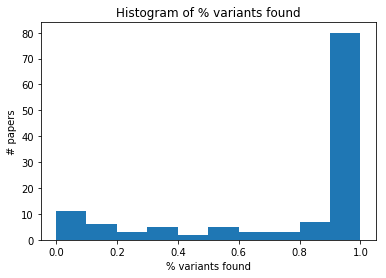

In [22]:
# Compute per paper the % of LOVD variants we found and exported in literature.json
pcts = {
    p: len(set(lit_variants_by_pmid[p]).intersection(
        set(lovd[lovd.pmid == p].pyhgvs_Genomic_Coordinate_38.values))) / len(
        set(lovd[lovd.pmid == p].pyhgvs_Genomic_Coordinate_38.values)) 
    for p in common_pmids}

lovd_stats = pd.DataFrame.from_dict(pcts, orient="index", columns=["pct"]).rename_axis("pmid")

# import matplotlib.pyplot as plt
# plt.hist(lovd_stats.pct)
# plt.title("Histogram of % variants found")
# plt.xlabel("% variants found")
# plt.ylabel("# papers")
# plt.show()

## Compare Current LOVD

In [23]:
# with open("/home/jovyan/public_html/literature-2018-11-14.json") as f:
with open("/home/jovyan/public_html/literature-2019-02-28-v2.json") as f:
    cur_lit = json.loads(f.read())
print("Current {} Papers and {} Variants exported".format(len(cur_lit["papers"]), len(cur_lit["variants"])))


# Invert the literature.json exported to BRCA Exchange to create a variants by pmid from literature
# NOTE Old format
import itertools

cur_lit_pmid_variant_tuple = [(hit["pmid"], variant)
                          for variant, hits in lit["variants"].items()
                          for hit in hits]

cur_lit_variants_by_pmid = {pmid: [v[1] 
                        for v in variants]
                        for pmid, variants in itertools.groupby(sorted(cur_lit_pmid_variant_tuple), lambda x: x[0])}



# cur_lit_pmid_variant_tuple = [(pmid, variant) 
#                           for variant, mention in cur_lit["variants"].items() 
#                           for pmid in list(mention.keys())]

# cur_lit_variants_by_pmid = {pmid: [v[1] 
#                         for v in variants]
#                         for pmid, variants in itertools.groupby(sorted(cur_lit_pmid_variant_tuple), lambda x: x[0])}

Current 3701 Papers and 9886 Variants exported


In [28]:
len(lit["papers"]) - len(cur_lit["papers"])

260

In [24]:
def confusion_matrix(lit_variants_by_pmid):
    TP, FP, FN, TN = 0, 0, 0, -1

    # Only evaluate papers in lovd and crawled
    for pmid in set([p for p in lovd.pmid.values if p in lit_variants_by_pmid.keys()]):
        actual = set(lovd[lovd["pmid"] == pmid].pyhgvs_Genomic_Coordinate_38.values)
        predicted = set(lit_variants_by_pmid[pmid])

        TP += len(predicted.intersection(actual))
        FP += len(predicted - actual)
        FN += len(actual - predicted)
#         TN += len(set(predicted.union(actual))) - (TP + FP + FN)
        
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)

    return TP, FP, FN, TN, precision, recall 

TP, FP, FN, TN, precision, recall = confusion_matrix(cur_lit_variants_by_pmid)

print("Current Production Confusion Matrix:")
print("{}\t{}".format(TP, FP))
print("{}\t{}".format(FN, TN))
print("Precision: {:.1%} Recall: {:.1%}".format(precision, recall))

TP, FP, FN, TN, precision, recall = confusion_matrix(lit_variants_by_pmid)

print("New Confusion Matrix w/o Points Ranking:")
print("{}\t{}".format(TP, FP))
print("{}\t{}".format(FN, TN))
print("Precision: {:.1%} Recall: {:.1%}".format(precision, recall))

Current Production Confusion Matrix:
1137	2448
659	-1
Precision: 31.7% Recall: 63.3%
New Confusion Matrix w/o Points Ranking:
1137	2448
659	-1
Precision: 31.7% Recall: 63.3%


## Debug

In [35]:
lit["variants"]["chr17:g.43057062:T>TG"]

[{'mentions': [' The following three common mutations have been identified in Ashkenazi Jewish (AJ) BRCA1/2 mutation carriers: c.68_69delAG (185delAG or 187delAG) and<<< c.5266dupC>>> (5382insC or 5385insC) in BRCA1 and c.5946delT (6174delT) in BRCA2.23–25 The prevalence of these mutations is approximately 2.5% in AJs.2,26,27 5382i',
   'On the origin and diffusion of BRCA1<<< c.5266dupC>>> (5382insC) in European populations.',
   ' The following three common mutations have been identified in Ashkenazi Jewish (AJ) BRCA1/2 mutation carriers: c.68_69delAG (185delAG or 187delAG) and<<< c.5266dupC>>> (5382insC or 5385insC) in BRCA1 and c.5946delT (6174delT) in BRCA2.23-25 The prevalence of these mutations is approximately 2.5% in AJs.2,26,27 5382i'],
  'pmid': '22430266',
  'points': 22},
 {'mentions': ['(Under this convention, the two mutations commonly referred to as “185delAG” and “5382insC” are named 187delAG and<<< 5385insC>>>, respectively.',
   'ants.  In fact, one variant that fall

In [31]:
lit["papers"]["10030809"]

KeyError: '10030809'

In [ ]:


print("pmid\t\tpoints\t#snips")
for hit in lit["variants"]["chr17:g.43057062:T>TG"]:
    print("{}\t{}\t{}".format(
        hit["pmid"], hit["points"], len(hit["mentions"])))